In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip -q install clu
    %load_ext tensorboard
    from google.colab import drive

    drive.mount("/content/drive")
    %cd '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers'
    # %tensorboard \
    # --logdir '/content/drive/MyDrive/Colab Notebooks/Hephaestus/Transformers/runs' \

In [24]:
import os
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import chain

import hephaestus_jax_copy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import seaborn as sns
from flax import linen as nn
from flax import struct  # Flax dataclasses

from flax.training import train_state
from jax import random
from jax.config import config
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange

# config.update("jax_debug_nans", True)

# Load and preprocess the dataset (assuming you have a CSV file)
df = pd.read_csv("../data/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
dataset = hp.TabularDS(df, target_column="price")

In [4]:
mtm = hp.MTM(dataset, n_heads=4)
trm = hp.TRM(dataset, n_heads=4)

In [5]:
batch_size = 3
test_num = dataset.X_train_numeric[0:batch_size, :]
test_num_mask = hp.mask_tensor(test_num, dataset)
test_cat = dataset.X_test_categorical[0:batch_size, :]
test_cat_mask = hp.mask_tensor(test_cat, dataset)

In [21]:
root_key = random.PRNGKey(0)
main_key, params_key, dropout_key = random.split(root_key, 3)

mtm_variables = mtm.init(
    params_key,
    test_num_mask,
    test_cat_mask,
)

trm_variables = trm.init(
    params_key,
    test_num_mask,
    test_cat_mask,
)

In [23]:
mtm_out = mtm.apply(
    {"params": mtm_variables["params"]},
    test_num_mask,
    test_cat_mask,
)
print(mtm_out[0].shape, mtm_out[1].shape)
mtm_out[0][0:2][0:2][0][0]

(3, 9, 33) (3, 6)


Array([-0.01410149, -0.49547863, -0.35137582, -0.8870763 ,  0.79824317,
        2.8491035 ,  0.4228595 , -0.60248655,  0.43630356, -0.20939958,
        0.13353364, -0.46332315,  0.39786044, -0.79767835,  2.1800725 ,
       -0.54361415,  0.6436009 ,  0.8725158 , -1.2810177 ,  1.0404757 ,
       -0.86332214, -0.8661479 ,  0.40740582, -0.567937  , -1.7694595 ,
        1.3314137 ,  1.9584402 ,  0.57486606, -0.33218223, -1.0444801 ,
       -0.5798579 , -0.6535781 ,  1.4346951 ], dtype=float32)

In [22]:
regression_out = trm.apply(
    {"params": trm_variables["params"]},
    test_num_mask,
    test_cat_mask,
    rngs={"dropout": jax.random.PRNGKey(43)},
)
regression_out

Array([[ 0.71065265,  0.7480822 ,  0.24531503,  0.54713434,  0.5178533 ,
         0.5160565 ,  0.5028162 ,  0.45168388,  0.60446984],
       [-0.10788787, -0.5165977 ,  0.42545068, -0.35905543, -0.3491014 ,
        -0.34558508, -0.3547202 , -0.356868  , -0.33591303],
       [ 0.675419  ,  0.8485132 ,  0.79987687,  0.6038695 ,  0.56150347,
         0.5325718 ,  0.57486206,  0.51628655,  0.6515242 ]],      dtype=float32)

In [10]:
@struct.dataclass
class ModelInputs:
    categorical_mask: jnp.ndarray
    numeric_mask: jnp.ndarray
    numeric_targets: jnp.ndarray
    categorical_targets: jnp.ndarray


def create_mi(dataset, idx, batch_size):
    numeric_col_tokens = dataset.numeric_col_tokens.clone()
    categorical_values = dataset.X_train_categorical[idx : idx + batch_size, :]
    categorical_mask = hp.mask_tensor(categorical_values, dataset)
    numeric_targets = dataset.X_train_numeric[idx : idx + batch_size, :]
    numeric_mask = hp.mask_tensor(numeric_targets, dataset)
    repeated_numeric_col_tokens = jnp.tile(
        numeric_col_tokens, (categorical_values.shape[0], 1)
    )
    categorical_targets = jnp.concatenate(
        [
            categorical_values,
            repeated_numeric_col_tokens,
        ],
        axis=1,
    )
    mi = ModelInputs(
        categorical_mask=categorical_mask,
        numeric_mask=numeric_mask,
        numeric_targets=numeric_targets,
        categorical_targets=categorical_targets,
    )
    return mi


mi = create_mi(dataset, 0, 3)
# print(mi)
mi.categorical_targets

Array([[13, 17, 14,  3,  7,  8, 10, 11, 12],
       [29, 22, 30,  3,  7,  8, 10, 11, 12],
       [29, 17, 18,  3,  7,  8, 10, 11, 12]], dtype=int32)

In [11]:
mi.numeric_mask

Array([[ 1.0169901 ,         nan,  0.24292836,  1.0687251 ,         nan,
         1.1070919 ],
       [-0.9872004 , -0.45330256, -1.099672  , -1.1153616 , -1.0633923 ,
        -1.1176738 ],
       [-0.52307206, -0.66271085, -0.65213853, -0.37544647,         nan,
                nan]], dtype=float32)

In [25]:
def calculate_loss(
    params,
    mtm,
    mi: ModelInputs,
):
    logits, regression = mtm.apply(
        {"params": params},
        mi.numeric_mask,
        mi.categorical_mask,
    )
    categorical_loss = optax.softmax_cross_entropy_with_integer_labels(
        logits, mi.categorical_targets
    ).mean()
    numeric_loss = optax.squared_error(regression, mi.numeric_targets).mean()
    total_loss = categorical_loss + numeric_loss * 2

    return {
        "total_loss": total_loss,
        "categorical_loss": categorical_loss,
        "numeric_loss": numeric_loss,
    }


calculate_loss(mtm_variables["params"], mtm, mi)

TypeError: Cannot interpret value of type <class 'hephaestus_jax_copy.MTM'> as an abstract array; it does not have a dtype attribute

In [13]:
def create_train_state(params_key, mi, lr=0.01):
    model = hp.MTM(dataset, d_model=64, n_heads=4)

    params = model.init(params_key, mi.numeric_mask, mi.categorical_mask)["params"]
    tx = optax.adam(learning_rate=lr)

    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

In [14]:
@jax.jit
def train_step(state, mi):
    def loss_fn(params):
        return calculate_loss(params, mtm, mi)["total_loss"]

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grad = grad_fn(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss


@jax.jit
def eval_step(params, mi):
    return calculate_loss(params, mtm, mi)

In [15]:
epochs = 100
total_loss = []
categorical_loss = []
numeric_loss = []
state = create_train_state(params_key, mi)

for epoch in range(epochs):
    mi = create_mi(dataset, 0, batch_size)
    state, loss = train_step(state, mi)
    loss_dict = eval_step(state.params, mi)
    total_loss.append(loss_dict["total_loss"].item())
    categorical_loss.append(loss_dict["categorical_loss"].item())
    numeric_loss.append(loss_dict["numeric_loss"].item())
    # all_losses.append(loss.item())
    # logger.add_scalar("Loss/train", loss.item(), i)

total_loss = jnp.array(total_loss)
categorical_loss = jnp.array(categorical_loss)
numeric_loss = jnp.array(numeric_loss)

<Axes: >

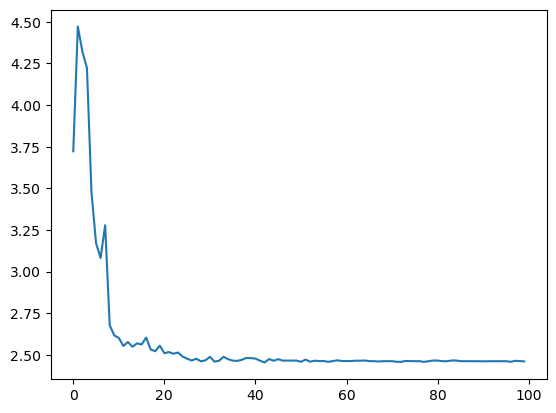

In [16]:
# plot all_losses
sns.lineplot(categorical_loss)

In [17]:
categorical_loss.min()

Array(2.4539943, dtype=float32)

In [18]:
numeric_loss.min()

Array(0.587294, dtype=float32)

<Axes: >

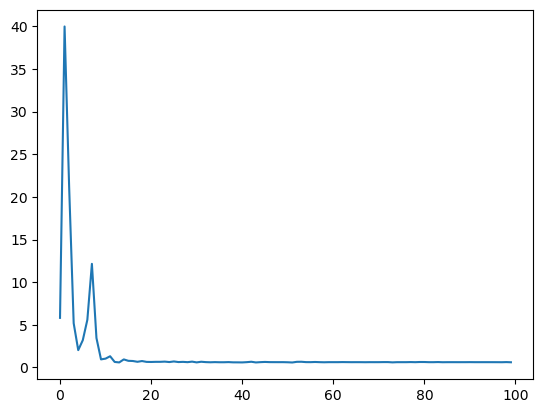

In [19]:
sns.lineplot(numeric_loss)

<Axes: >

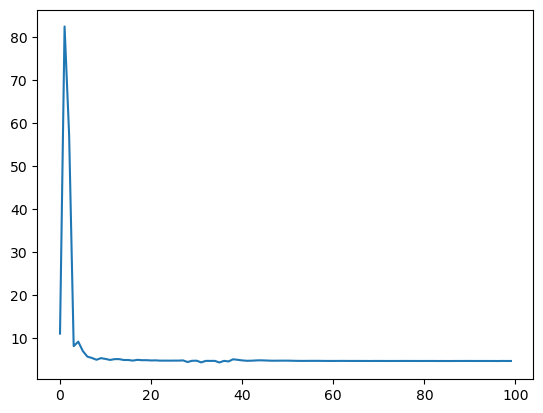

In [20]:
sns.lineplot(total_loss)

In [18]:
total_loss.min()

Array(2.5287564, dtype=float32)

In [19]:
def replace_nans_with_zeros(n):
    x = has_nans
    mask = jnp.isnan(x)
    return jnp.where(mask, n, x)


replace_nans_with_zeros(has_nans)
jax.grad(replace_nans_with_zeros)(0.0)

NameError: name 'has_nans' is not defined

In [ ]:
def safe_for_grad_log(x):
    return jnp.log(jnp.where(x > 0.0, x, 1.0))


safe_for_grad_log(0.0)  # ==> 0.  # Ok
jax.grad(safe_for_grad_log)(0.0)  #  ==> 0.  # Ok

Array(0., dtype=float32, weak_type=True)

In [ ]:
jnp.where(mask, arr, 0.0)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
jnp.where(
    arr == float("nan"),
)

TypeError: where requires ndarray or scalar arguments, got <class 'NoneType'> at position 2.